# Monitoraggio Dati COVID-19 Italia

© Copyright 2020, Pietro Di Gangi

Raw data sources:
* COVID-19 data from Dipartimento della Protezione Civile: https://github.com/pcm-dpc/COVID-19
* Population data from  ISTAT (01/01/2019)

In [635]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [636]:
%run ../../init.py

Current time: 2020-04-02 19:08:49.056469


In [637]:
#############################################
# Useful functions
#############################################
def delta(data, variables):
    '''Tasso di crescita mediato sugli ultimi 1,2,3,4 giorni'''
    for var in variables: 
        for dayspan in [1,2,3,4]:
            colname = var+'_delta'+str(dayspan)
            data[colname] = 0
            for i in np.arange(dayspan):
                data[colname] = data[colname] + data['new_'+var].shift(i)/data[var].shift(i+1)
            data[colname] = data[colname]/dayspan    
    return data

def sorted_set(data, regions, var, norm=False):
    '''Ordina set rispetto alla variabile var'''
    df = data[data.region.isin(regions)][data.date==lastday].sort_values(var, ascending=False)
    regions = df.region.unique()
    return regions

def leglabels_style():
    '''Make legend labels colored'''
    leg._legend_box.align = "left"
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
        
def format_dateaxis():
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()

In [652]:
#############################################
# Read data from github repo: https://github.com/pcm-dpc/COVID-19
# Dipartimento della Protezione Civile
#############################################
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
ita = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
regioni = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
prov = pd.read_csv(url)

#############################################
# Manipulate dataframes
#############################################
# Italia #################
ita = ita.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'deceduti' : 'deaths',
    'tamponi' : 'tests',
    'dimessi_guariti': 'recovered',
})
ita['date'] = ita['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
ita['new_cases'] = ita['cases'].diff()
ita['new_deaths'] = ita['deaths'].diff()
ita['new_recovered'] = ita['recovered'].diff()
ita['new_tests'] = ita['tests'].diff()
ita['new_terapia_intensiva'] = ita['terapia_intensiva'].diff()



# Nord, Centro, Sud #################
nord = ['Lombardia', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Liguria', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Valle d\'Aosta', 'Veneto']
centro = ['Abruzzo', 'Lazio', 'Marche', 'Molise', 'Toscana', 'Umbria']
sud = ['Basilicata', 'Calabria', 'Campania', 'Puglia', 'Sardegna', 'Sicilia']
def zone(region):
    if region in nord:
        return 'Nord'
    elif region in centro:
        return 'Centro'
    elif region in sud:
        return 'Sud'
    else: print('Error: No zone assigned to region!')


# Regioni #################
regioni = regioni.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'deceduti' : 'deaths',
    'denominazione_regione' : 'region',
    'tamponi' : 'tests',
    'dimessi_guariti': 'recovered'
})
regioni['date'] = regioni['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
regioni['zone'] = regioni['region'].map(lambda location: zone(location))
regioni = regioni.sort_values(['region', 'date'])
regioni['new_cases'] = regioni['cases'].diff()
regioni['new_deaths'] = regioni['deaths'].diff()
regioni['new_recovered'] = regioni['recovered'].diff()
regioni['new_tests'] = regioni['tests'].diff()
regioni['new_terapia_intensiva'] = regioni['terapia_intensiva'].diff()

# Aree (Nord, Centro, Sud) #################
aree = regioni.groupby(['zone', 'date'],as_index=False).sum()
aree['region'] = aree['zone']


# Province #################
prov = prov.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'denominazione_regione' : 'region',
    'denominazione_provincia' : 'province',
    'sigla_provincia' : 'acronym',
})
prov['date'] = prov['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
prov = prov.sort_values(['province', 'date'])
prov['new_cases'] = prov['cases'].diff()


# Tassi di incremento ################
ita = delta(ita, ['cases', 'deaths', 'recovered', 'tests'])
regioni = delta(regioni, ['cases', 'deaths', 'recovered', 'tests'])
aree = delta(aree, ['cases', 'deaths', 'recovered', 'tests'])
prov = delta(prov, ['cases'])


# Summary of Regioni #################
# Dati popolazione ISTAT 01/01/2019
population = {
    'Lombardia': 10.04e6,
    'Emilia-Romagna': 4.45e6,
    'Veneto': 4.91e6,
    'Piemonte': 4.38e6,
    'Marche': 1.53e6,
    'Toscana': 3.74e6,
    'Liguria': 1.56e6,
    'Lazio': 5.90e6,
    'Campania': 5.83e6,
    'Friuli Venezia Giulia': 1.22e6,
    'P.A. Trento': 541e3,
    'P.A. Bolzano': 531e3,
    'Puglia': 4.05e6,
    'Abruzzo': 1.32e6,
    'Sicilia': 4999891,
    'Umbria': 885e3,
    'Sardegna': 1.65e6,
    'Valle d\'Aosta': 126e3,
    'Calabria': 1.96e6,
    'Basilicata': 567e3,
    'Molise': 308e3,
    'Nord': 27758000,
    'Centro': 13683000,
    'Sud': 19056891,
    'Italia': 60497891
}
summary = pd.DataFrame(columns=['region', 'cases'])
for regione in regioni.region.unique():
    summary = summary.append({
        'region': regione, 
        'cases': regioni[regioni['region']==regione].cases.iat[-1],
        'new_cases': regioni[regioni['region']==regione].new_cases.iat[-1],
        'deaths': regioni[regioni['region']==regione].deaths.iat[-1],
        'new_deaths': regioni[regioni['region']==regione].new_deaths.iat[-1],
        'terapia_intensiva': regioni[regioni['region']==regione].terapia_intensiva.iat[-1],},
        ignore_index=True
    )
summary['area'] = summary['region'].map(lambda region: zone(region))
summary['population'] = summary['region'].map(lambda region: population[region])
summary['positive_percentage'] = summary.apply(lambda row: row.cases/row.population*100, axis = 1) 
summary = summary.sort_values('positive_percentage', ascending=False)

cases_area = summary.groupby(['area'],as_index=False)['cases'].sum()
population_area = summary.groupby(['area'],as_index=False)['population'].sum()
population_ita = sum(population.values())

lastday = ita.date.iat[-1]
print('Last data update:', lastday)

Last data update: 2020-04-02 17:00:00


# Tabella Dati Regionali

In [639]:
print('Sommario dati regionali aggiornati a:', lastday)
summary

Sommario dati regionali aggiornati a: 2020-04-02 17:00:00


region  cases  deaths  new_cases  new_deaths  \
19          Valle d'Aosta    668    63.0       37.0         4.0   
8               Lombardia  46065  7960.0     1292.0       367.0   
12            P.A. Trento   2003   187.0      133.0        14.0   
4          Emilia-Romagna  15333  1811.0      546.0        79.0   
11           P.A. Bolzano   1479   129.0       61.0        13.0   
9                  Marche   4098   503.0      136.0        26.0   
7                 Liguria   3782   488.0      122.0        28.0   
13               Piemonte  10353   983.0      558.0        97.0   
20                 Veneto  10111   532.0      486.0        33.0   
5   Friuli Venezia Giulia   1799   129.0      114.0         7.0   
17                Toscana   5273   268.0      406.0        15.0   
18                 Umbria   1128    38.0       33.0         1.0   
0                 Abruzzo   1497   133.0       61.0        10.0   
6                   Lazio   3433   185.0      169.0        16.0   
10                 Molise    165    11.0        5.0         1.0   
14                 Puglia   2077   144.0      131.0        15.0   
15               Sardegna    794    40.0       49.0         6.0   
1              Basilicata    246    10.0        9.0         1.0   
3                Campania   2456   167.0      225.0        19.0   
16                Sicilia   1791    93.0       73.0         5.0   
2                Calabria    691    41.0       22.0         3.0   

    terapia_intensiva    area  population  positive_percentage  
19               25.0    Nord    126000.0             0.530159  
8              1351.0    Nord  10040000.0             0.458815  
12               78.0    Nord    541000.0             0.370240  
4               366.0    Nord   4450000.0             0.344562  
11               60.0    Nord    531000.0             0.278531  
9               164.0  Centro   1530000.0             0.267843  
7               172.0    Nord   1560000.0             0.242436  
13              453.0    Nord   4380000.0             0.236370  
20              345.0    Nord   4910000.0             0.205927  
5                60.0    Nord   1220000.0             0.147459  
17              295.0  Centro   3740000.0             0.140989  
18               47.0  Centro    885000.0             0.127458  
0                75.0  Centro   1320000.0             0.113409  
6               181.0  Centro   5900000.0             0.058186  
10                8.0  Centro    308000.0             0.053571  
14              118.0     Sud   4050000.0             0.051284  
15               24.0     Sud   1650000.0             0.048121  
1                19.0     Sud    567000.0             0.043386  
3               120.0     Sud   5830000.0             0.042127  
16               73.0     Sud   4999891.0             0.035821  
2                19.0     Sud   1960000.0             0.035255

# 1D Diagnostic Plots
Andamento delle singole variabili relative ai casi COVID-19 tramite grafici 1D.

## Valori normalizzati su popolazione: dati cumulati
Totale casi COVID-19 confermati per 100000 abitanti in Italia (Nord, Centro e Sud)
* Bars: i contributi delle singole aree sono sovrapposti

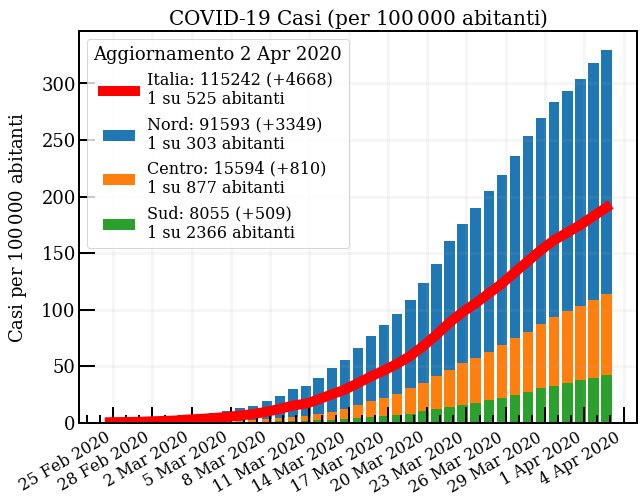

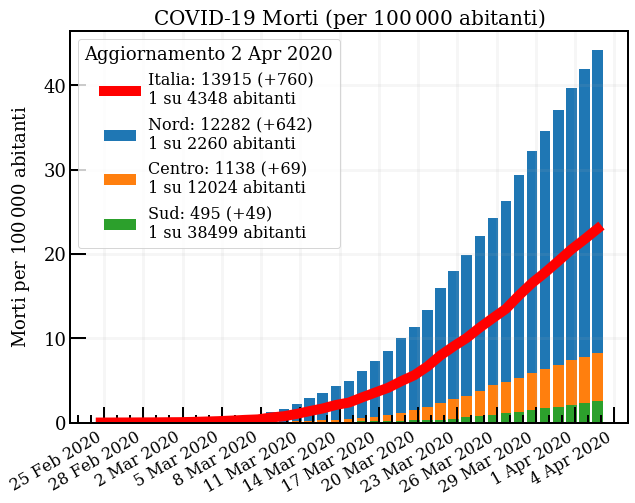

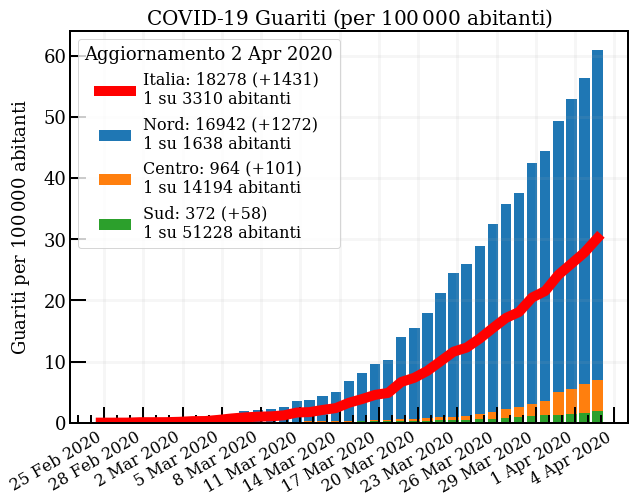

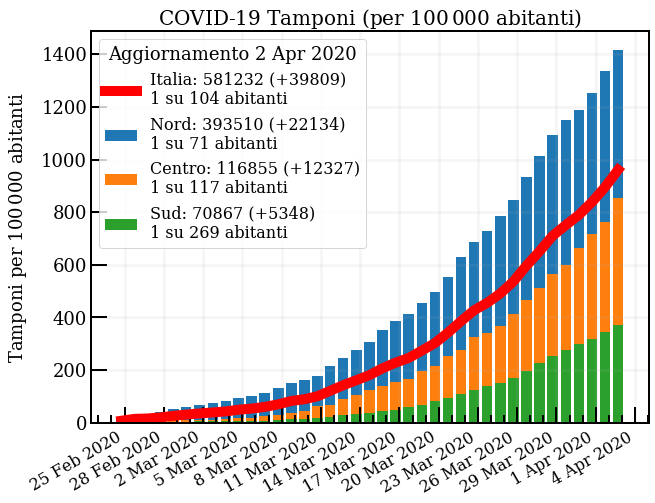

In [640]:
def cumulative_ita_normalized(data, var, title='', ylabel='y'):

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    regions = ['Nord', 'Centro', 'Sud']
    N = len(regions)
    
    # plot data
    for i,state in enumerate(regions):
        df = data[data.zone==state]
        pop = population_area[population_area.area==state]['population'].iat[0]        
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (state, tot, df['new_'+var].iat[-1])
        lb = lb + '\n1 su %.f abitanti' % (pop/tot)
        ax.bar(df.date, df[var]/pop*1e5, label=lb)
    
    pop = population_ita       
    tot = ita[var].iat[-1]
    lb = 'Italia: %d (+%.f)' % (tot, ita['new_'+var].iat[-1])
    lb = lb + '\n1 su %.f abitanti' % (pop/tot)
    ax.plot(ita.date, ita[var]/pop*1e5, label=lb, color='r', lw=10, ls='-')

    # axes settings
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    
    
cumulative_ita_normalized(aree, 'cases', title='COVID-19 Casi (per 100$\,$000 abitanti)', ylabel='Casi per 100$\,$000 abitanti')
cumulative_ita_normalized(aree, 'deaths', title='COVID-19 Morti (per 100$\,$000 abitanti)', ylabel='Morti per 100$\,$000 abitanti')
cumulative_ita_normalized(aree, 'recovered', title='COVID-19 Guariti (per 100$\,$000 abitanti)', ylabel='Guariti per 100$\,$000 abitanti')
cumulative_ita_normalized(aree, 'tests', title='COVID-19 Tamponi (per 100$\,$000 abitanti)', ylabel='Tamponi per 100$\,$000 abitanti')

## Valori normalizzati su popolazione: dati differenziali
Nuovi casi giornalieri COVID-19 per 100000 abitanti in Italia (Nord, Centro e Sud)

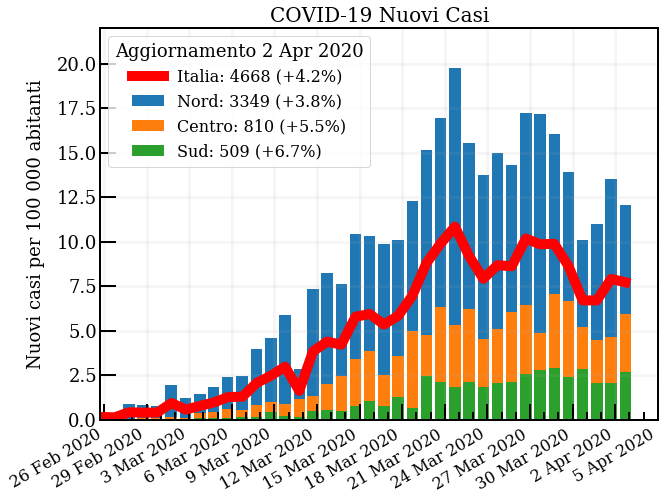

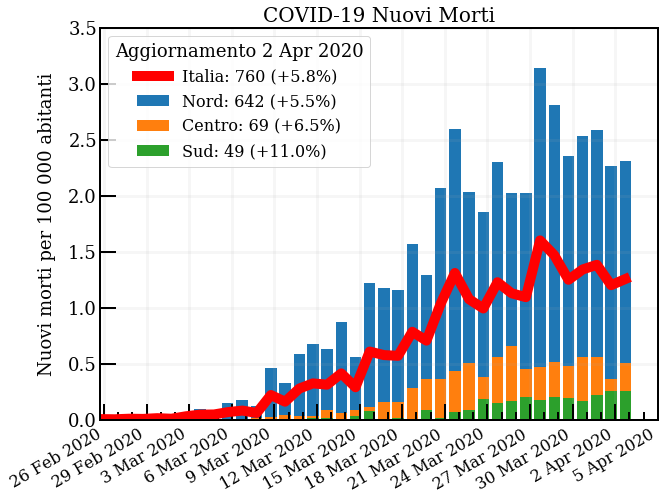

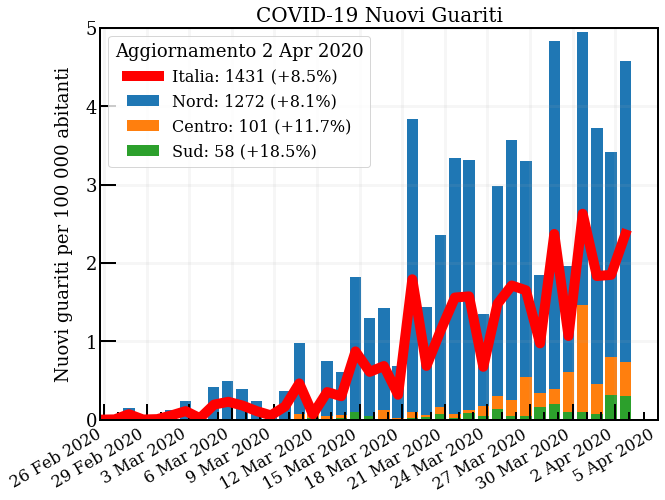

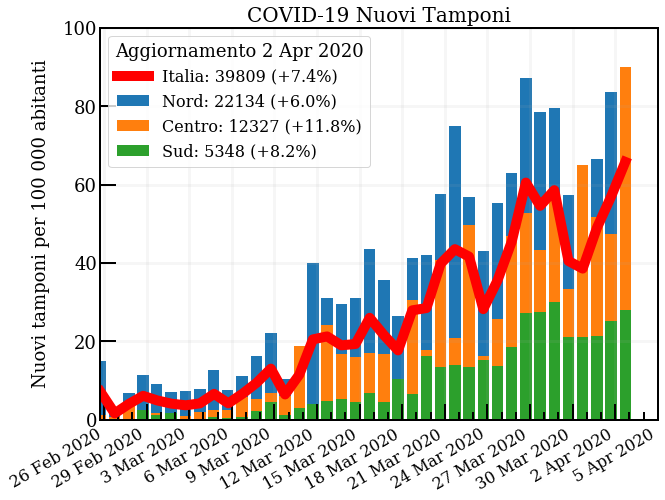

In [641]:
def differential_ita_normalized(data, var, title='', ylabel='y per 100 000 abitanti', ymax=100):
    cumvar = var.replace("new_", "")

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    regions = ['Nord', 'Centro', 'Sud']
    N = len(regions)
    
    # plot data
    for i,state in enumerate(regions):
        df = data[data.zone==state]
        pop = population_area[population_area.area==state]['population'].iat[0]        
        tot = df[var].iat[-1]
        lb = '%s: %.f (+%.1f%s)' % (state, tot, df[cumvar+'_delta1'].iat[-1]*100, '%')
        ax.bar(df.date, df[var]/pop*1e5, label=lb)
    
    df = ita
    pop = population_ita       
    tot = df[var].iat[-1]
    lb = 'Italia: %.f (+%.1f%s)' % (tot, df[cumvar+'_delta1'].iat[-1]*100, '%')
    ax.plot(df.date, df[var]/pop*1e5, label=lb, color='r', lw=10, ls='-')

    # axes settings
    ax.set_xlim(left = df.date.iat[1])
    ax.set_ylim(0,ymax)
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    
    
differential_ita_normalized(aree, 'new_cases', 
                                  title = 'COVID-19 Nuovi Casi', 
                                  ylabel = 'Nuovi casi per 100 000 abitanti',
                                  ymax = 22
                                 )

differential_ita_normalized(aree, 'new_deaths', 
                                  title = 'COVID-19 Nuovi Morti', 
                                  ylabel = 'Nuovi morti per 100 000 abitanti',
                                  ymax = 3.5
                                 )

differential_ita_normalized(aree, 'new_recovered', 
                                  title = 'COVID-19 Nuovi Guariti', 
                                  ylabel = 'Nuovi guariti per 100 000 abitanti',
                                  ymax = 5
                                 )

differential_ita_normalized(aree, 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi per 100 000 abitanti',
                                  ymax = 100
                                 )

## Valori assoluti: dati cumulati
Numero assoluto di casi COVID-19 confermati in Italia (Nord, Centro e Sud)
* Casi confermati
* Morti
* Guariti
* Tamponi effettuati

**Tipologia grafico**: Stacked bars - I contributi delle diverse aree sono impilati uno sopra l'altro

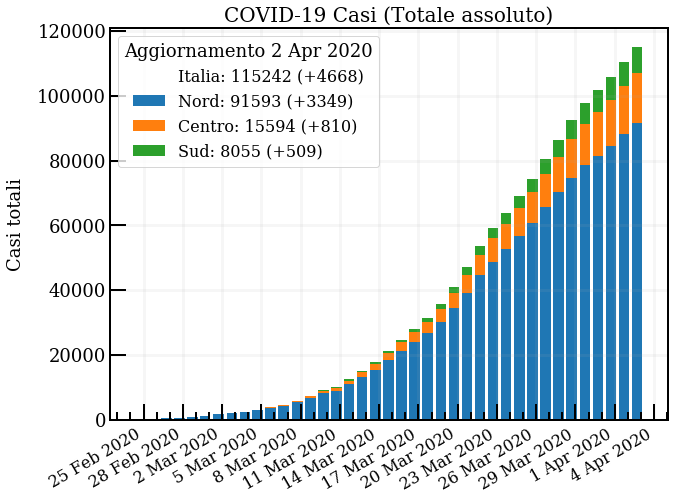

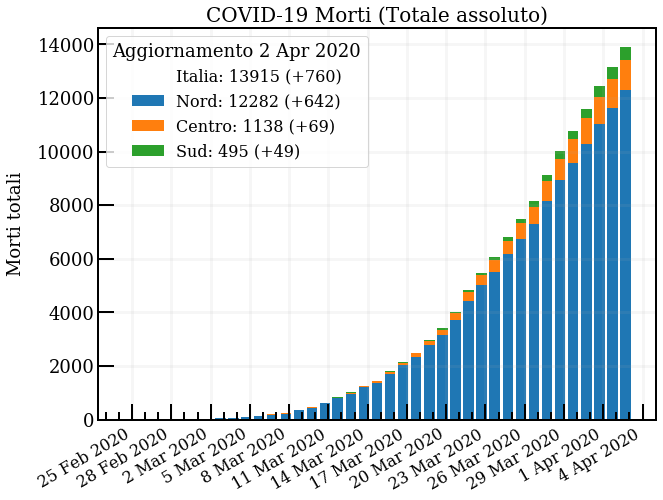

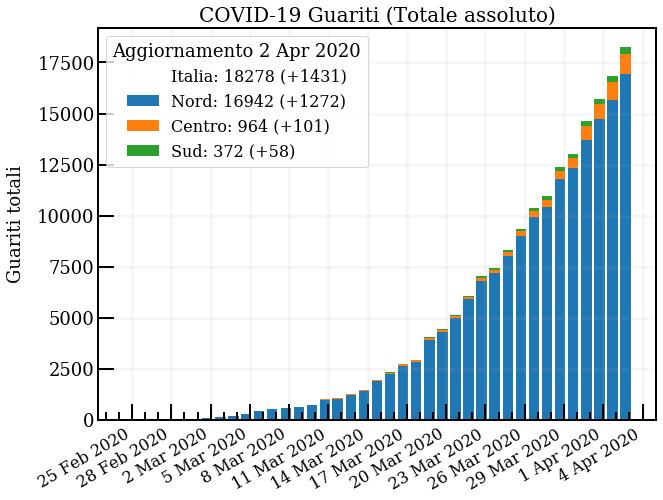

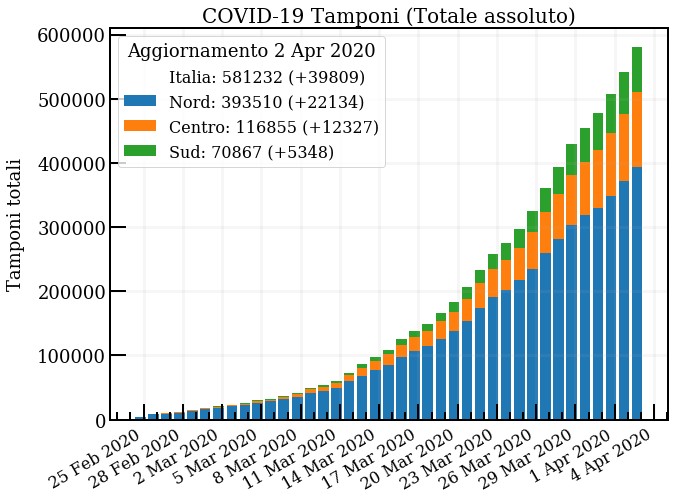

In [642]:
def cumulative_ita(data, var, title='', ylabel='y'):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    regions = ['Nord', 'Centro', 'Sud']
    colors = ['tab:blue', "tab:orange","tab:green"]
    N = len(regions)

    margin_bottom = np.zeros(len(data['date'].drop_duplicates()))
    for i,state in enumerate(regions):
        df = data[data.zone==state]
        pop = population_area[population_area.area==state]['population']        
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (state, tot, df['new_'+var].iat[-1])

        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values
    
    lb = 'Italia: %d (+%.f)' % (ita[var].iat[-1], ita['new_'+var].iat[-1])
    ax.plot(ita.date, ita[var], label=lb, color='r', lw=5, ls='-', alpha=0)
    
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    
    
cumulative_ita(aree, 'cases', title='COVID-19 Casi (Totale assoluto)', ylabel='Casi totali')
cumulative_ita(aree, 'deaths', title='COVID-19 Morti (Totale assoluto)', ylabel='Morti totali')
cumulative_ita(aree, 'recovered', title='COVID-19 Guariti (Totale assoluto)', ylabel='Guariti totali')
cumulative_ita(aree, 'tests', title='COVID-19 Tamponi (Totale assoluto)', ylabel='Tamponi totali')

## Valori assoluti: dati differenziali
Variazione assoluta giornaliera di casi COVID-19 in Italia (Nord, Centro e Sud).
* Stacked bars: i contributi delle diverse aree sono impilati uno sopra l'altro

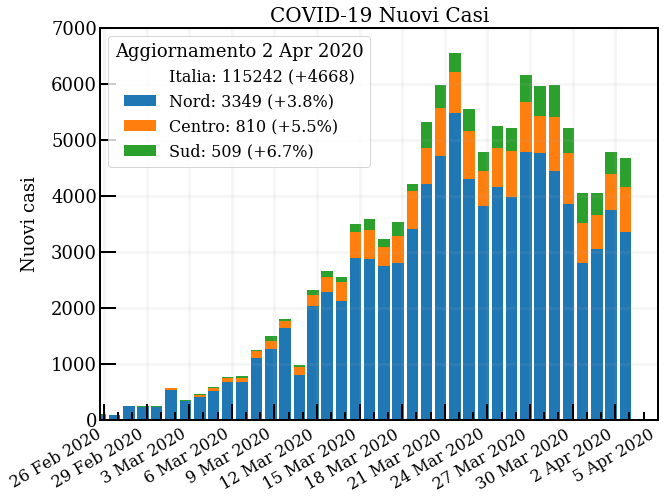

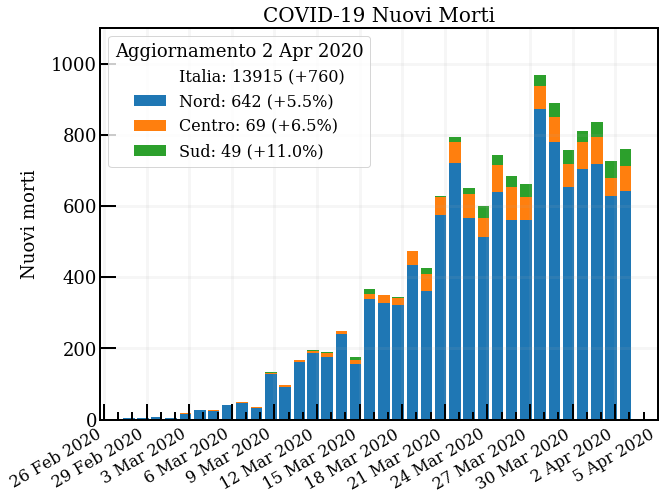

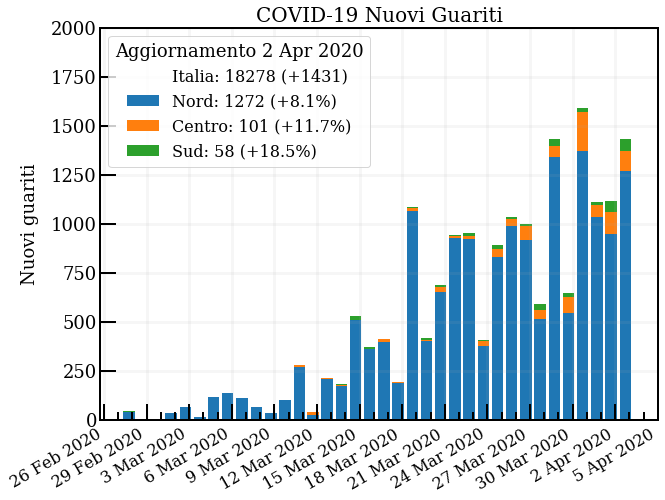

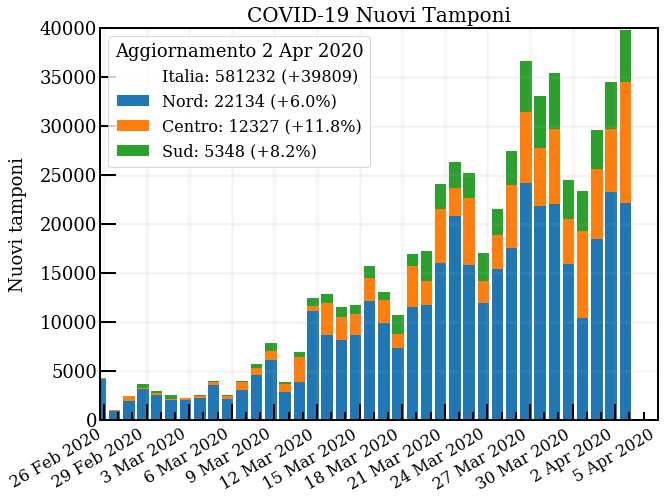

In [643]:
def differential_ita(data, var, title='', ylabel='y', ymax=100):
    cumvar = var.replace("new_", "")

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    regions = ['Nord', 'Centro', 'Sud']
    N = len(regions)    
    
    # plot data
    margin_bottom = np.zeros(len(data['date'].drop_duplicates()))
    for i,state in enumerate(regions):
        df = data[data.zone==state]
        pop = population_area[population_area.area==state]['population'].iat[0]        
        tot = df[var].iat[-1]
        lb = '%s: %.f (+%.1f%s)' % (state, tot, df[cumvar+'_delta1'].iat[-1]*100, '%')
        
        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values
    
    df = ita
    lb = 'Italia: %d (+%.f)' % (df[cumvar].iat[-1], df[var].iat[-1])
    ax.plot(df.date, df[var], label=lb, color='r', lw=5, ls='-', alpha=0)

    # axes settings
    ax.set_xlim(left = df.date.iat[1])
    ax.set_ylim(0,ymax)
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    
    
differential_ita(aree, 'new_cases', 
                                  title = 'COVID-19 Nuovi Casi', 
                                  ylabel = 'Nuovi casi',
                                  ymax = 7000
                                 )

differential_ita(aree, 'new_deaths', 
                                  title = 'COVID-19 Nuovi Morti', 
                                  ylabel = 'Nuovi morti',
                                  ymax = 1100
                                 )

differential_ita(aree, 'new_recovered', 
                                  title = 'COVID-19 Nuovi Guariti', 
                                  ylabel = 'Nuovi guariti',
                                  ymax = 2000
                                 )

differential_ita(aree, 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi',
                                  ymax = 40000
                                 )

# Overview COVID-19
Dati cumulati (valore accumulato fino ad oggi):
* Tamponi effettuati
* Casi confermati
* Dimessi guariti
* Morti

Dati attuali (valore registrato oggi):
* Attualmente positivi
* Ospedalizzati
* Ricoverati con sintomi
* In isolamento domiciliare
* In terapia intensiva

## Italia
Andamento e valori complessivi in Italia (Nord, Centro, Sud)

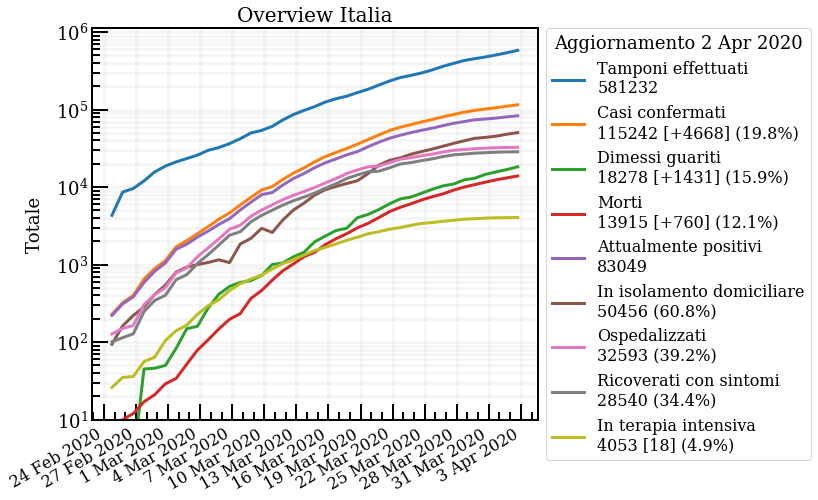

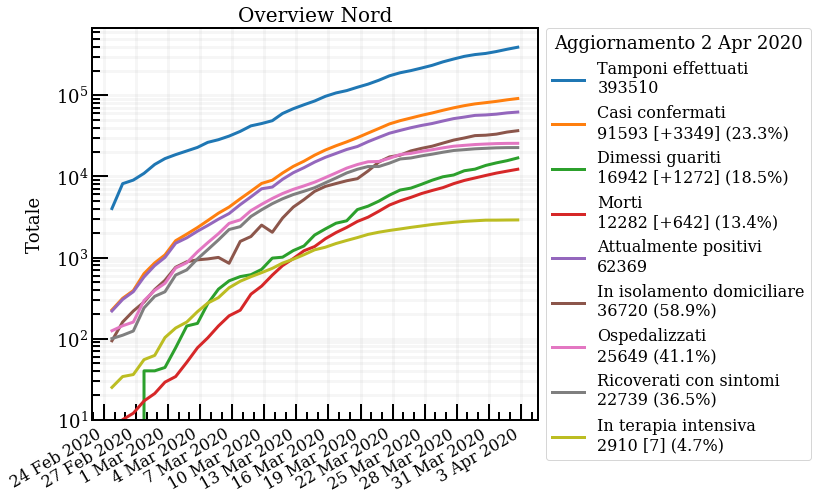

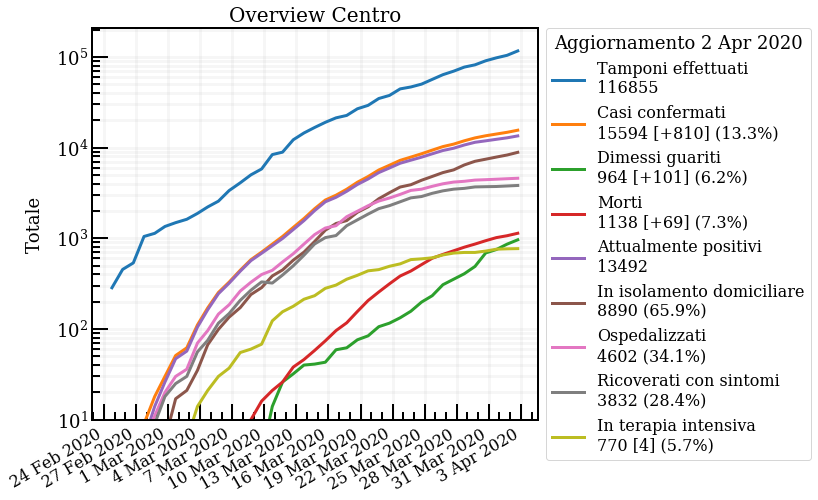

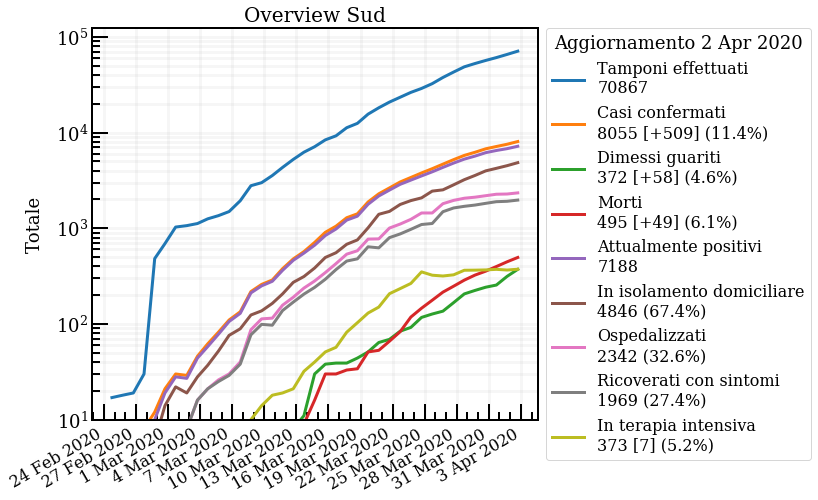

In [644]:
def overview(data, title=''):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    regions = ['Nord', 'Centro', 'Sud']
    colors = ['tab:blue', "tab:orange","tab:green"]
    N = len(regions)

   
    # dati cumulati
    ax.plot(data.date, data.tests, label='Tamponi effettuati\n%d' % data.tests.iat[-1])
    lb = 'Casi confermati\n%d [+%.f]' % (data.cases.iat[-1], data.new_cases.iat[-1])
    lb = lb + ' (%.1f%s)' % (data.cases.iat[-1]/data.tests.iat[-1]*100, '%')
    ax.plot(data.date, data.cases, label=lb)
    lb = 'Dimessi guariti\n%d [+%.f]' % (data.recovered.iat[-1], data.new_recovered.iat[-1])
    lb = lb + ' (%.1f%s)' % (data.recovered.iat[-1]/data.cases.iat[-1]*100, '%')
    ax.plot(data.date, data.recovered, label=lb)
    lb = 'Morti\n%d [+%.f]' % (data.deaths.iat[-1], data.new_deaths.iat[-1])
    lb = lb + ' (%.1f%s)' % (data.deaths.iat[-1]/data.cases.iat[-1]*100, '%')
    ax.plot(data.date, data.deaths, label=lb)
    
    # dati attuali
    ax.plot(data.date, data.totale_positivi, label='Attualmente positivi\n%d' % data.totale_positivi.iat[-1])
    tot = data.isolamento_domiciliare.iat[-1]
    pc = tot/data.totale_positivi.iat[-1]
    ax.plot(data.date, data.isolamento_domiciliare, label='In isolamento domiciliare\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = data.totale_ospedalizzati.iat[-1]
    pc = tot/data.totale_positivi.iat[-1]
    ax.plot(data.date, data.totale_ospedalizzati, label='Ospedalizzati\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = data.ricoverati_con_sintomi.iat[-1]
    pc = tot/data.totale_positivi.iat[-1]
    ax.plot(data.date, data.ricoverati_con_sintomi, label='Ricoverati con sintomi\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = data.terapia_intensiva.iat[-1]
    pc = tot/data.totale_positivi.iat[-1]
    new = data.new_terapia_intensiva.iat[-1]
    ax.plot(data.date, data.terapia_intensiva, label='In terapia intensiva\n%d [%.f] (%.1f%s)' % (tot, new, pc*100, '%'))
    


    plt.ylabel('Totale')
    plt.yscale('log')
    ax.set_ylim(bottom=10)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, bbox_to_anchor=(1.,1.02), title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    
    
overview(ita, 'Overview Italia')
for area in ['Nord', 'Centro', 'Sud']:
    overview(aree[aree.zone==area], 'Overview '+area)

## Regioni
Andamento e valori complessivi nelle singole regioni

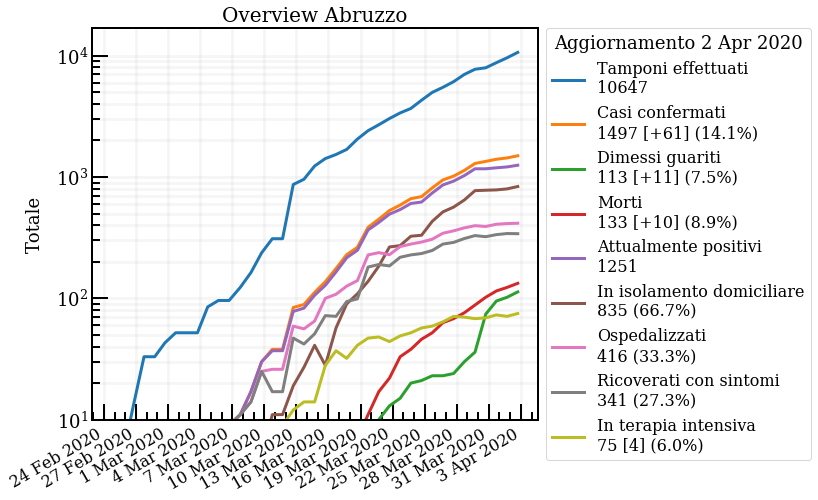

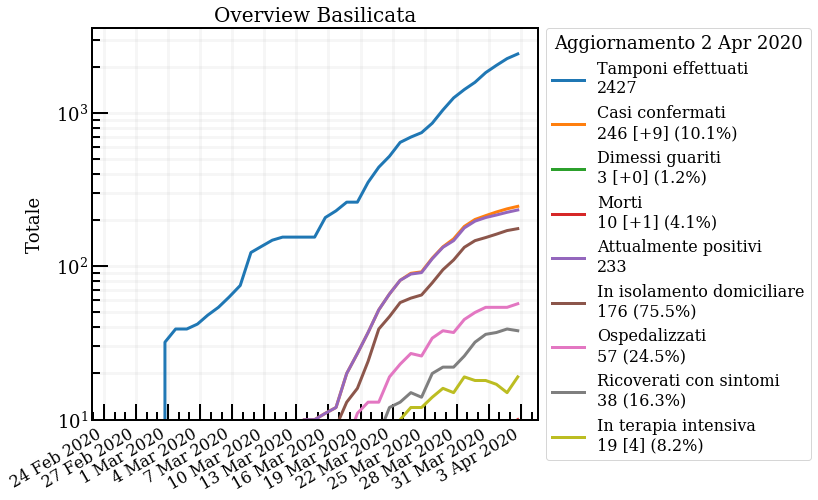

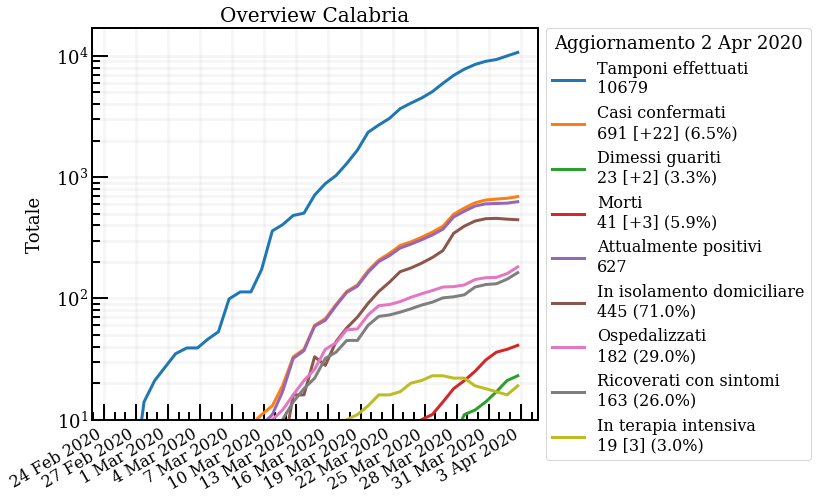

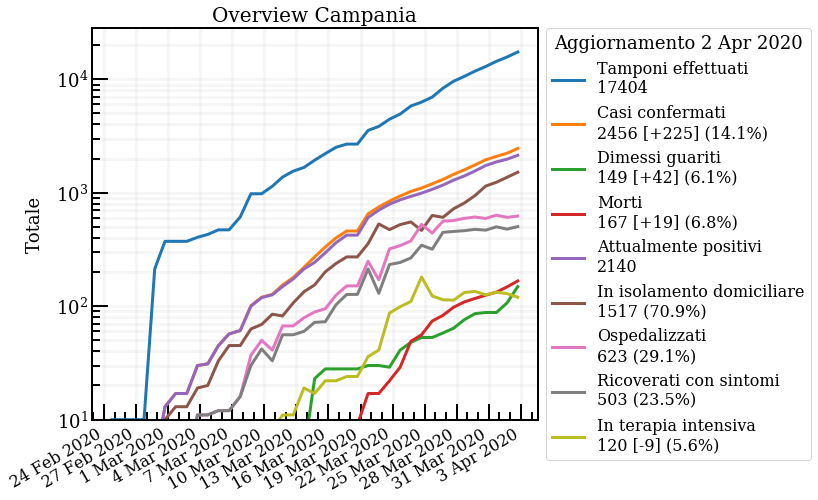

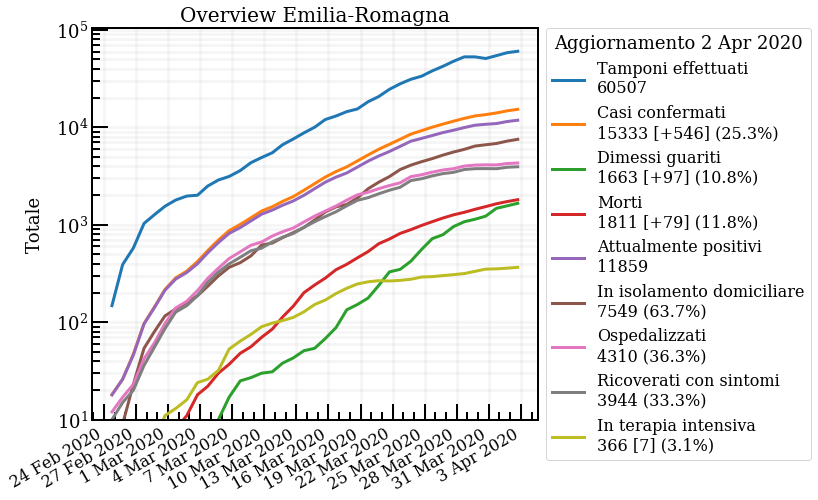

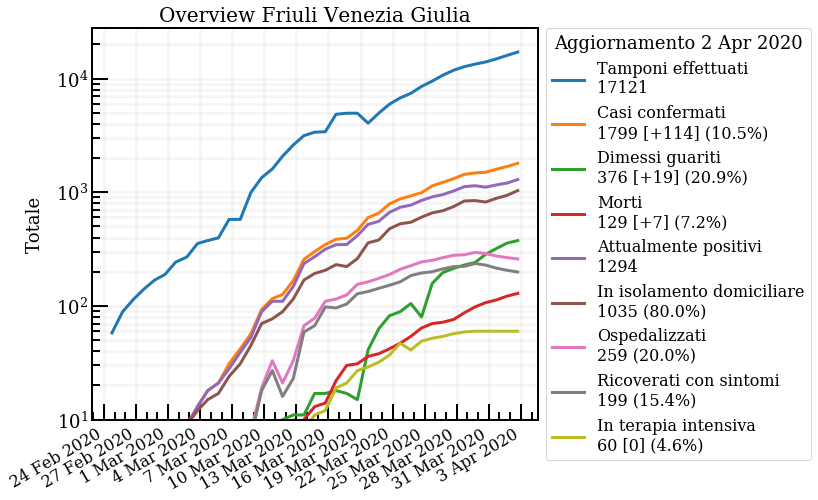

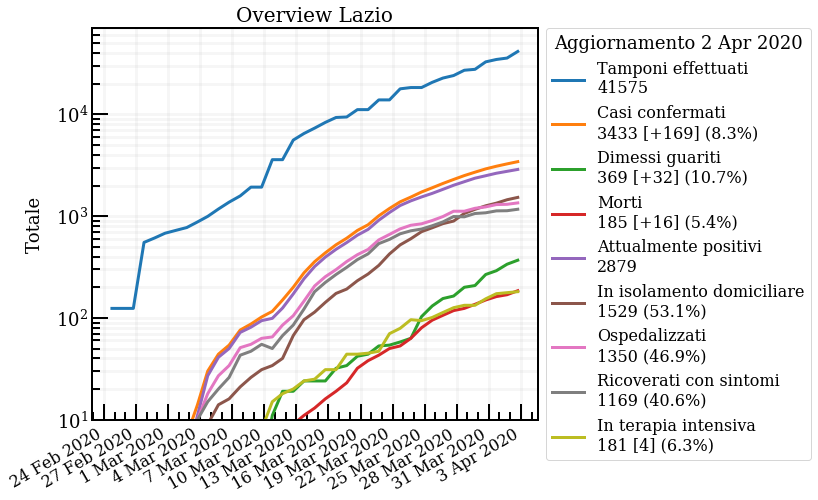

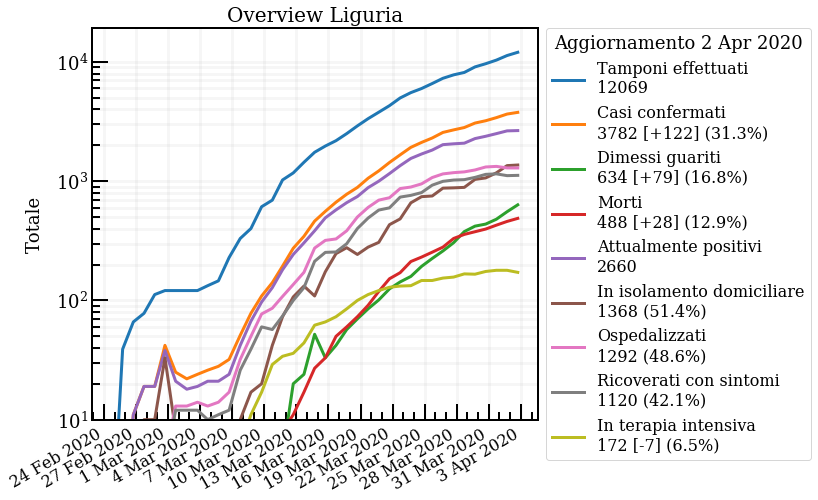

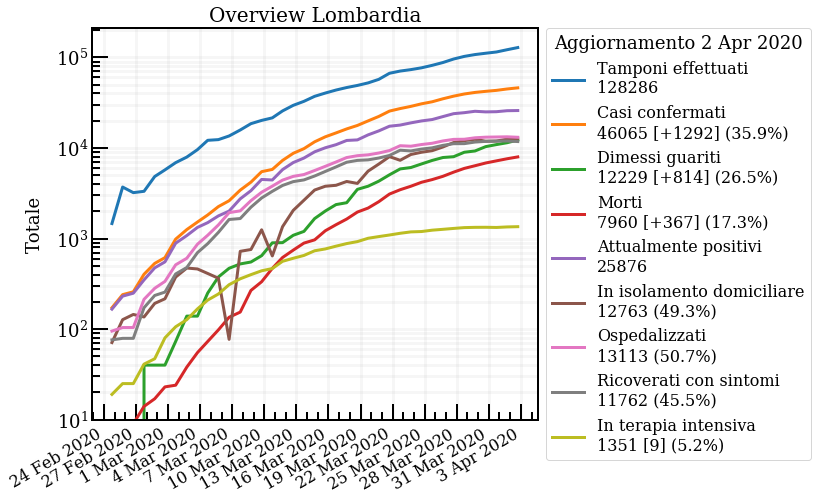

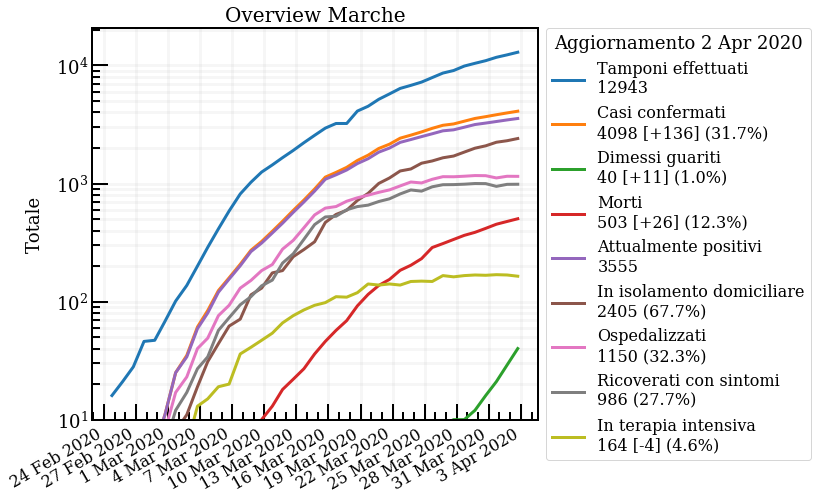

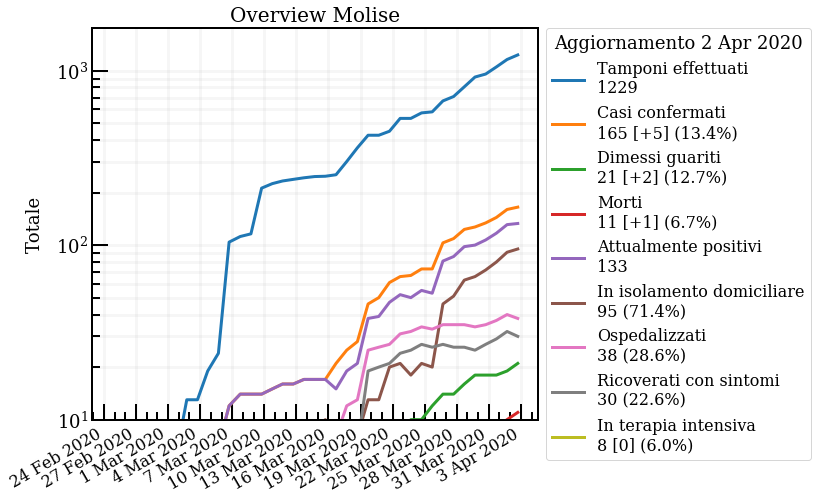

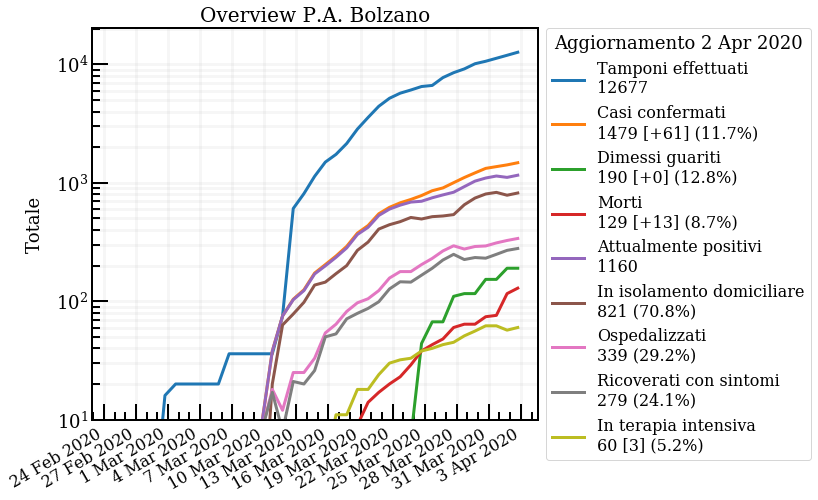

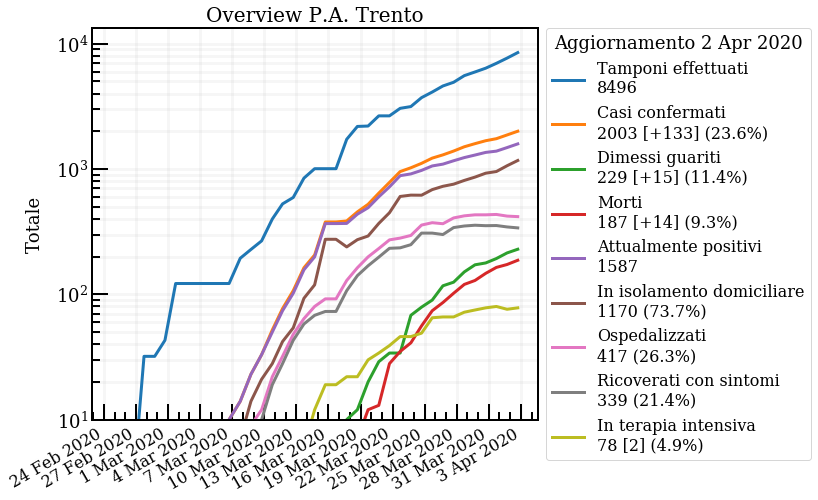

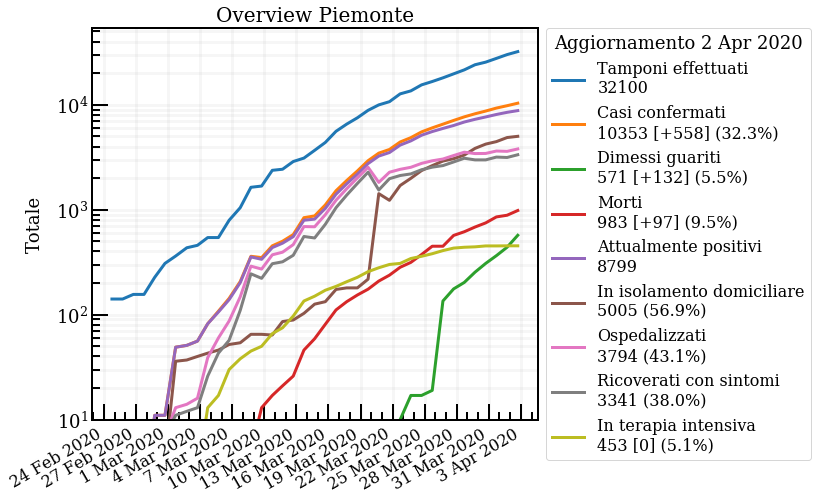

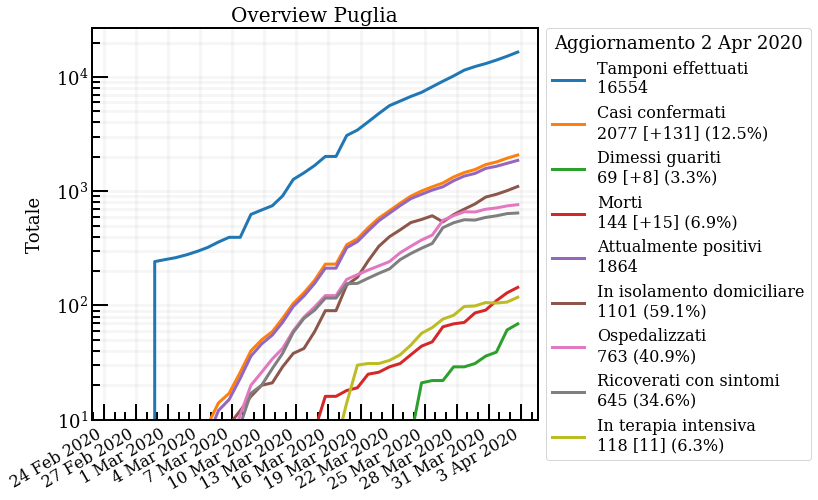

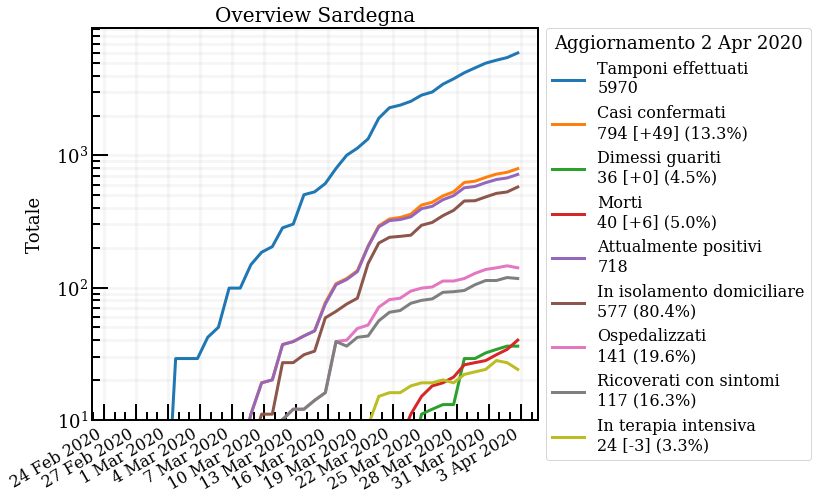

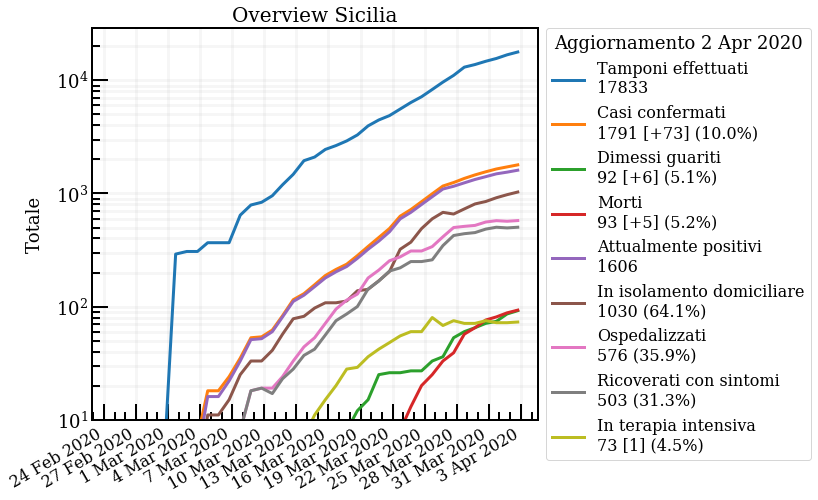

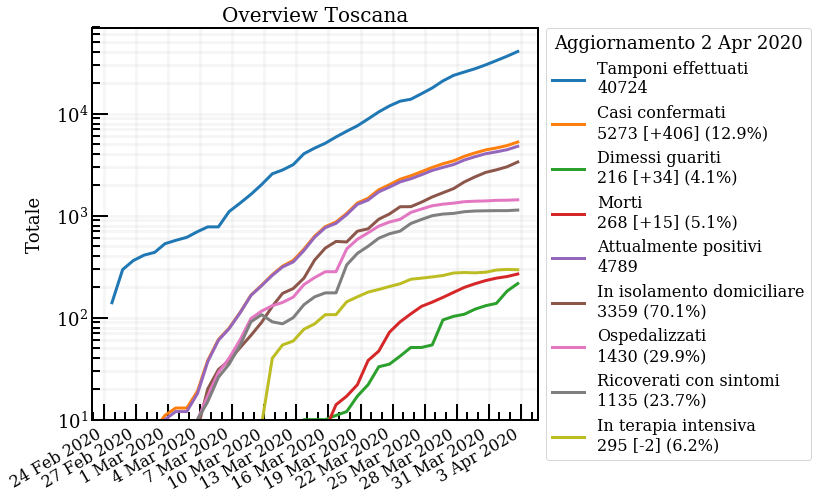

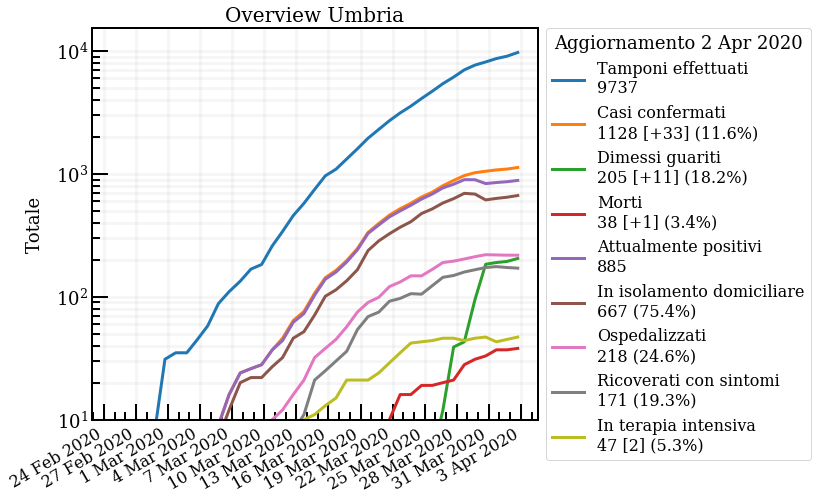

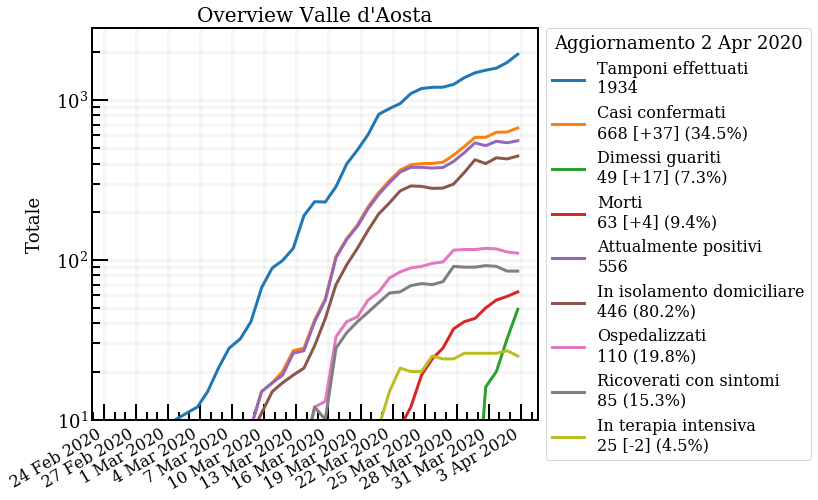

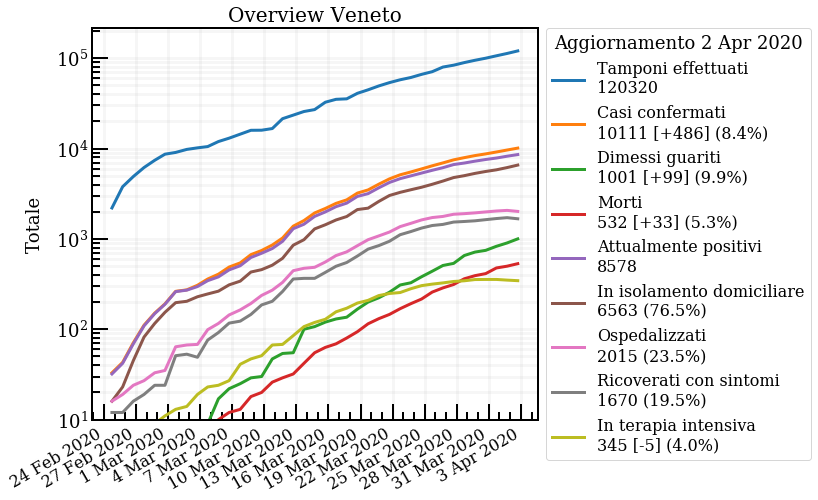

In [645]:
for regione in regioni['region'].unique():
    overview(regioni[regioni.region==regione], 'Overview '+regione)

# Trail Plots
Tracciamento dell'evoluzione dei dati (due variabili) tramite scie di punti in grafici 2D.

**Come interpretare il grafico:**
* Punti piu' trasparenti corrispondono a giorni precedenti
* La coppia di valori alla data attuale e' mostrata da un punto colorato (zero trasparenza)
* Una maggiore distanza fra i punti (lungo uno degli assi o entrambi) indica una maggiore rapidita' di evoluzione del dato su base giornaliera.


## Casi positivi - Casi in terapia intensiva
Evoluzione dei casi positivi (totale) e ricoveri in terapia intensiva (attuale) per regione.

**Effetto della neutralizzazione del virus:**
* Nessun avanzamento lungo l'asse dei casi totali
* Caduta dei punti verso lo zero dell'asse dei casi in terapia intensiva

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


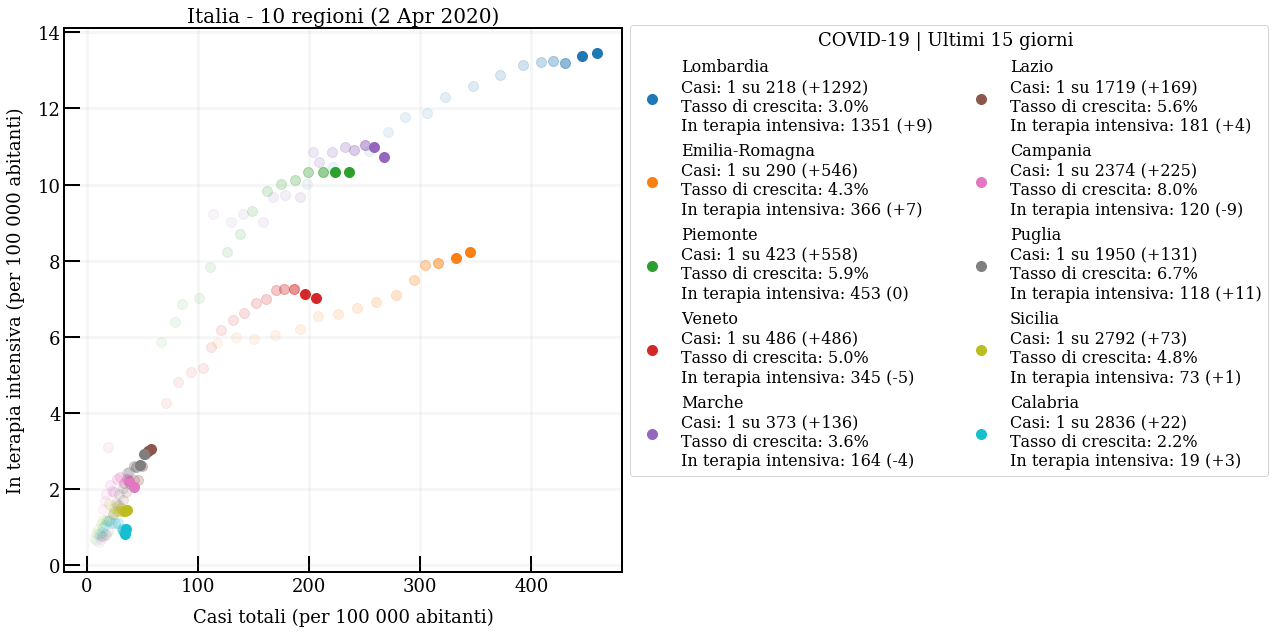

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


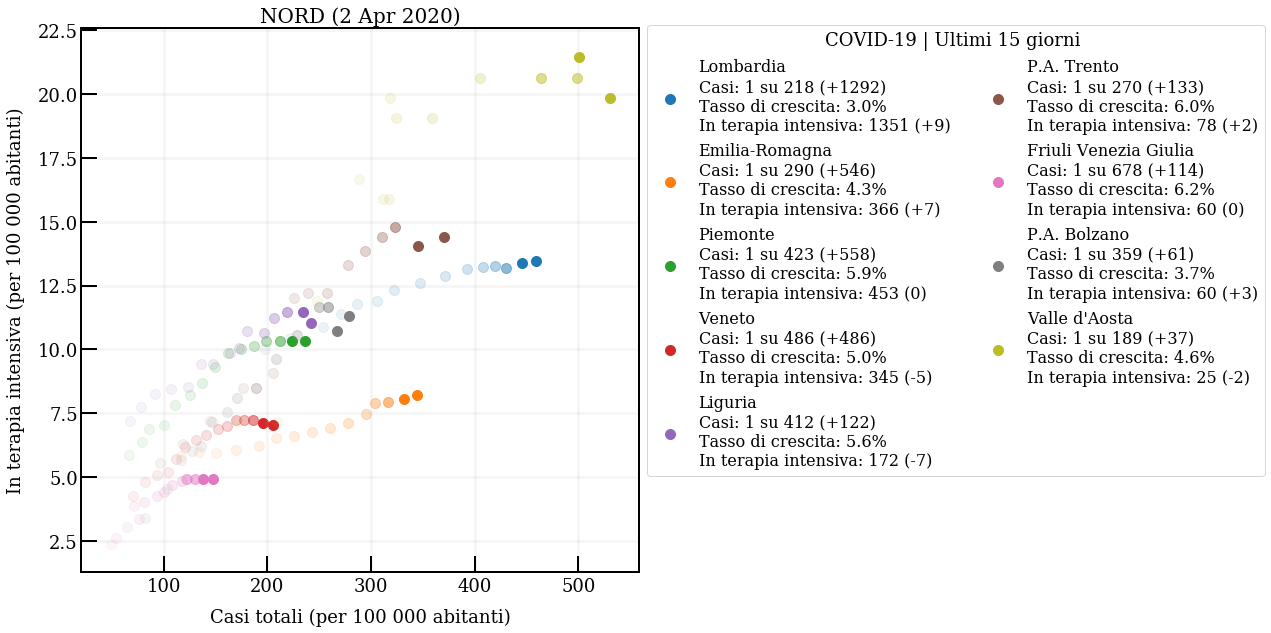

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


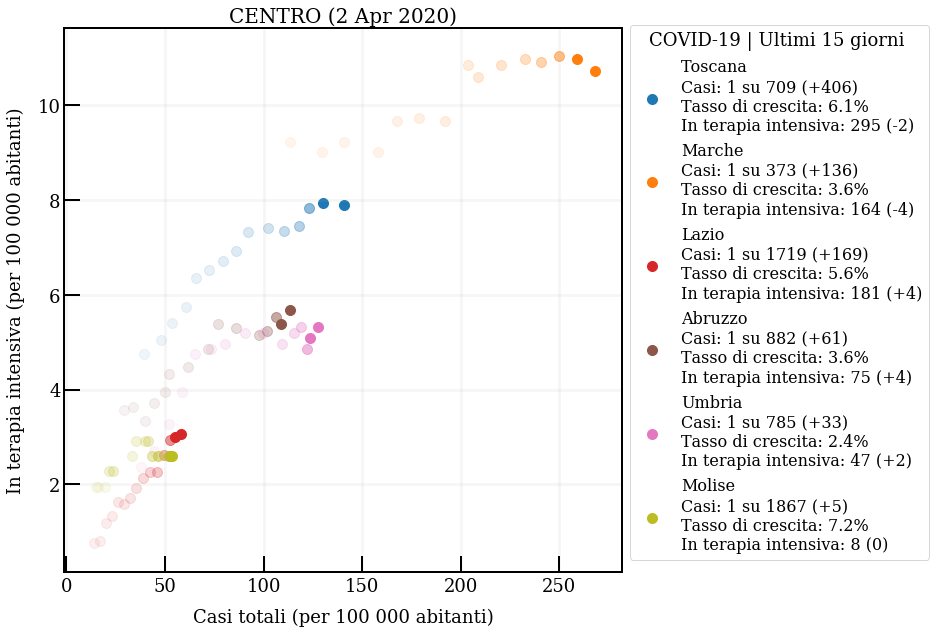

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


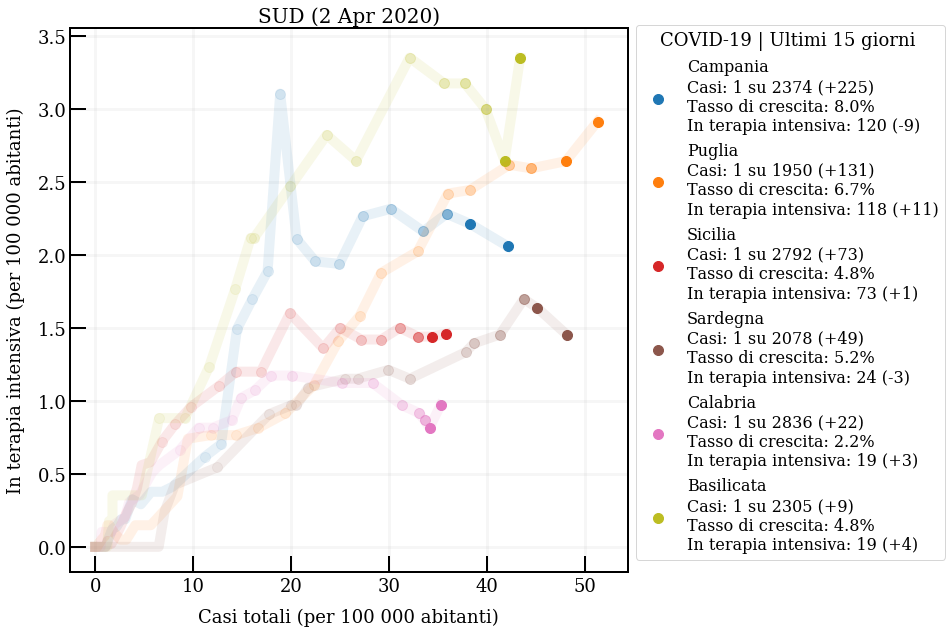

In [646]:
def pointevo_cases_icu(data, regions, dayspan, title='', line=False):
    vary = 'terapia_intensiva'
    varx = 'cases'
    regions = sorted_regions(regioni, regions, 'cases')
    N = len(regions)
    cm = plt.get_cmap('tab10')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    # plot curves
    ndays = dayspan
    days = np.arange(1,ndays)
    mk = 'o'
    ms=100

    for i,state in enumerate(regions):
        df = data[data.region==state]
        pop = population[state]
        totx = df[varx].iat[-1]
        toty = df[vary].iat[-1]
        normalization = pop/1e5

        lb = '%s\nCasi: 1 su %.f (+%.f)' % (state, pop/df.cases.iat[-1], df.new_cases.iat[-1])
        lb = lb + '\nTasso di crescita: %.1f%s' % (df.cases_delta3.iat[-1]*100, '%')
        sign = '+'
        if df.new_terapia_intensiva.iat[-1]<=0: sign=''
        lb = lb + '\nIn terapia intensiva: %d (%s%.f)' % (df.terapia_intensiva.iat[-1], sign, df.new_terapia_intensiva.iat[-1])
        if line:
            ax.plot(df[varx]/normalization, df[vary]/normalization, label='', color=cm(1.*i/N), lw=10, alpha=0.1)
        ax.scatter(df[varx].iat[-1]/normalization, df[vary].iat[-1]/normalization, label=lb, color=cm(1.*i/N), marker=mk, s=ms)

        for day in list(reversed(days)):
            x = df[varx].iat[-1-day]/normalization # total value 'day' ago
            y = df[vary].iat[-1-day]/normalization
            alpha = 1/day
            ax.scatter(x,y,label='', color=cm(1.*i/N), marker=mk, s=ms, alpha=alpha)

    plt.ylabel('In terapia intensiva (per 100 000 abitanti)')
    plt.xlabel('Casi totali (per 100 000 abitanti)')
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    
    #plt.text(0, ax.get_ylim()[1]*0.95, title, fontsize=24, horizontalalignment='left')
    #legend
    leg = plt.legend(loc='upper left', ncol=int(N/7)+1, bbox_to_anchor=(1.,1.02), 
                     title='COVID-19 | Ultimi %d giorni ' % ndays)
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)

    plt.show()
    
    
regions = ['Lombardia', 'Emilia-Romagna', 'Marche', 'Piemonte', 'Veneto', 'Puglia', 'Lazio', 'Sicilia', 'Calabria', 'Campania']
pointevo_cases_icu(regioni,regions,15, 'Italia - 10 regioni', 0)
regions = nord
pointevo_cases_icu(regioni,regions,15, 'NORD', 0)
regions = centro
pointevo_cases_icu(regioni,regions,15, 'CENTRO', 0)
regions = sud
pointevo_cases_icu(regioni,regions,15, 'SUD', 1)

## Casi confermati - Morti

No handles with labels found to put in legend.


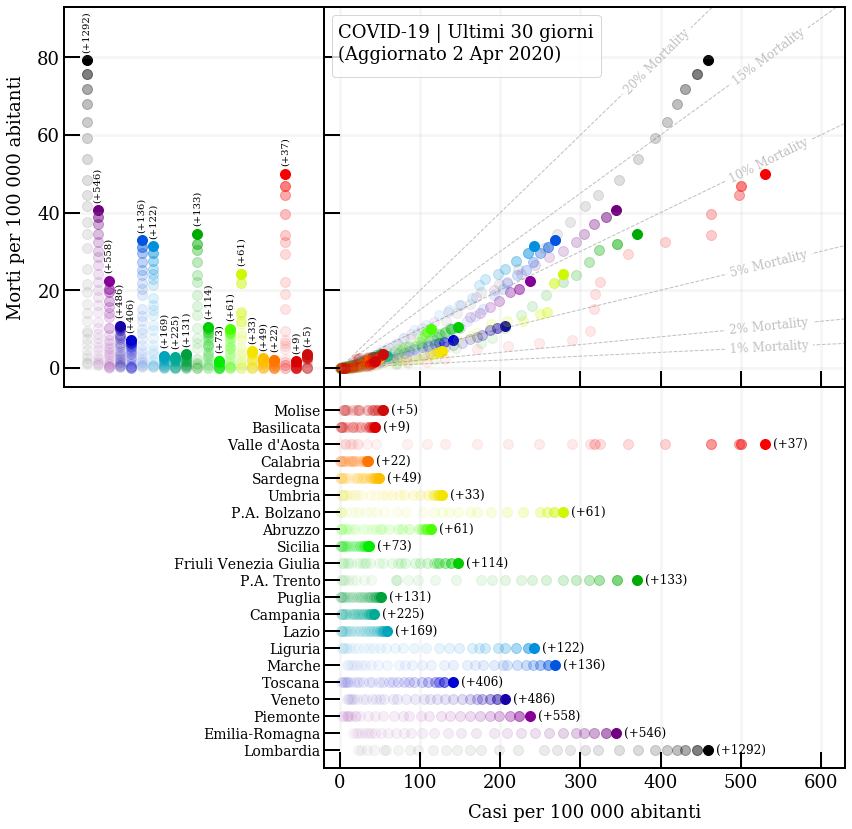

In [654]:
def guideline(ax=ax, xlim=(0,1), ylim=(0,1), m=1, label=''):
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    ax.plot((0,xmax), (0,m*xmax), ls='--', lw=1, color='silver', zorder=-100)

    mplot = (ymax-ymin)/(xmax-xmin)
    if m < mplot:
        coord = [0.85*xmax, 0.85*xmax*m]
    else:
        coord = [0.85*ymax/m, 0.85*ymax]
    label = '%.f%s ' % (m*100, '%') + label
    ax.text(coord[0], coord[1], label, color='silver', fontsize=12, rotation=np.rad2deg(np.arctan(m*5)), ha='center', va='center', backgroundcolor='w', zorder=-100)

def trailplot(data, states, ndays, varx, vary, xlabel, ylabel, xlim, ylim, guidelines):
    states = sorted_set(data, states, varx)

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(14,14))
    grid = plt.GridSpec(2, 3, hspace=0., wspace=0.)
    ax = fig.add_subplot(grid[:-1, 1:])
    y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
    x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
    x_ax.tick_params(axis='y', which='major', labelsize=14)

    # axes
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    y_ax.set_ylabel(ylabel+' per 100 000 abitanti')
    x_ax.set_xlabel(xlabel+' per 100 000 abitanti')

    # mortality guidelines
    for m in guidelines:
        guideline(ax=ax, xlim=xlim, ylim=ylim, m=m, label='Mortality')

    # plot curves
    days = np.arange(1,ndays)
    mk = 'o'
    ms=100
    #dummy points
    #x_ax.scatter(0,'',label='', color='w')
    y_ax.scatter('',0,label='', color='w')

    cmap = plt.get_cmap('nipy_spectral')
    for i,state in enumerate(states):
        color = cmap(i/len(states))
        df = data[data.region==state]
        pop = population[state]
        #ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]/pop*1e5, label='', color=color, marker=mk, s=ms)
        #x_ax.scatter(x,state,label='', color=color, marker=mk, s=ms, alpha=alpha)
        #y_ax.scatter(state,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        for day in list(reversed(days)):
            x = df[varx].iat[-day]/pop*1e5 # total value 'day' ago
            y = df[vary].iat[-day]/pop*1e5
            alpha = 1./day
            ax.scatter(x,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
            x_ax.scatter(x,state,label='', color=color, marker=mk, s=ms, alpha=alpha)
            y_ax.scatter(state,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        x_ax.text(x+10, state, '(+%d)' % df['new_'+varx].iat[-1], ha='left', va='center', fontsize=12)
        y_ax.text(state, y+2, '(+%d)' % df['new_'+varx].iat[-1], ha='center', va='bottom', fontsize=10, rotation=90)

    ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    x_ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    y_ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')

    #legend
    leg = ax.legend(loc='upper left', frameon=True, ncol=1, 
                     title='COVID-19 | Ultimi %d giorni\n(Aggiornato %s)' % (ndays, lastday.strftime('%-d %b %Y')))
    leglabels_style()

    plt.show()
    
trailplot(data=regioni, states=regioni.region.unique(), ndays=30,
          varx='cases', vary='deaths', xlabel='Casi', ylabel='Morti',
          xlim=(-20,630), ylim=(-5,93), guidelines=[0.2,0.15,0.1,0.05,0.02,0.01]
         )

